# diabetes dataset

In [1]:
# Imports
import numpy as np
import pandas as pd

# Opendataval
from opendataval.dataloader import Register, DataFetcher, mix_labels, add_gauss_noise
from opendataval.dataval import (
    AME,
    DVRL,
    BetaShapley,
    DataBanzhaf,
    DataOob,
    DataShapley,
    InfluenceFunctionEval,
    KNNShapley,
    LavaEvaluator,
    LeaveOneOut,
    RandomEvaluator,
    RobustVolumeShapley,
)

from opendataval.experiment import ExperimentMediator

[KeOps] Warning : Cuda libraries were not detected on the system ; using cpu only mode


## [Step 1] Set up an environment
`ExperimentMediator` is a fundamental concept in establishing the `opendataval` environment. It empowers users to configure hyperparameters, including a dataset, a type of synthetic noise, and a prediction model. With  `ExperimentMediator`, users can effortlessly compute various data valuation algorithms.

The following code cell demonstrates how to set up `ExperimentMediator` with a pre-registered dataset and a prediction model.
- Dataset: diabetes
- Model: sklearn's linear regression model
- Metric: negative mean squred error

In [2]:
dataset_name = "diabetes"
train_count, valid_count, test_count = 100, 50, 50
noise_rate = 0.1
noise_kwargs = {'noise_rate': noise_rate}
model_name = "sklinreg"
metric_name = "neg_mse"

exper_med = ExperimentMediator.model_factory_setup(
    dataset_name=dataset_name,
    cache_dir="../data_files/",  
    force_download=False,
    train_count=train_count,
    valid_count=valid_count,
    test_count=test_count,
    add_noise=add_gauss_noise,
    noise_kwargs=noise_kwargs,
    train_kwargs={},
    model_name=model_name,
    metric_name=metric_name
)

Base line model metric_name='neg_mse': perf=-4565.47802734375


A full list of registered datasets can be found [here](https://github.com/opendataval/opendataval/blob/main/opendataval/dataloader/fetcher.py#L121). A list of available  prediction models can be found [here](https://github.com/opendataval/opendataval/blob/main/opendataval/model/__init__.py#L111).

## [Step 2] Compute data values
`opendataval` provides various state-of-the-art data valuation algorithms. `ExperimentMediator.compute_data_values()` computes data values.

In [3]:
data_evaluators = [ 
    RandomEvaluator(),
    LeaveOneOut(), # leave one out
    InfluenceFunctionEval(num_models=1000), # influence function
    DVRL(rl_epochs=2000), # Data valuation using Reinforcement Learning
    KNNShapley(k_neighbors=valid_count), # KNN-Shapley
    DataShapley(gr_threshold=1.05, mc_epochs=300, cache_name=f"cached"), # Data-Shapley
    BetaShapley(gr_threshold=1.05, mc_epochs=300, cache_name=f"cached"), # Beta-Shapley
    DataBanzhaf(num_models=1000), # Data-Banzhaf
    AME(num_models=1000), # Average Marginal Effects
    DataOob(num_models=1000), # Data-OOB
    LavaEvaluator(),
    RobustVolumeShapley(mc_epochs=300)
]

In [4]:
%%time
# compute data values.
exper_med = exper_med.compute_data_values(data_evaluators=data_evaluators)

Elapsed time RandomEvaluator(): 0:00:00.000313


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 781.91it/s]


Elapsed time LeaveOneOut(): 0:00:00.132909


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 856.42it/s]


Elapsed time InfluenceFunctionEval(num_models=1000): 0:00:01.171666


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:06<00:00, 311.52it/s]


Elapsed time DVRL(rl_epochs=2000): 0:00:06.433236


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 13703.26it/s]

Elapsed time KNNShapley(k_neighbors=50): 0:00:00.013532
Start: marginal contribution computation



100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 123.59it/s]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 124.07it/s]


gr_stat=100


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 123.92it/s]

gr_stat=1.0148601349089323
Done: marginal contribution computation


Elapsed time DataShapley(gr_threshold=1.05, mc_epochs=300, cache_name=cached): 0:00:02.435373
Elapsed time BetaShapley(gr_threshold=1.05, mc_epochs=300, cache_name=cached): 0:00:00.000223


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 998.56it/s]


Elapsed time DataBanzhaf(num_models=1000): 0:00:01.007513


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 882.50it/s]


Elapsed time AME(num_models=1000): 0:00:03.869490


100%|███████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:01<00:00, 713.85it/s]


Elapsed time DataOob(num_models=1000): 0:00:01.405701


Elapsed time LavaEvaluator(): 0:00:00.021949


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:01<00:00, 205.17it/s]

Elapsed time RobustVolumeShapley(mc_epochs=300): 0:00:01.466005
CPU times: user 17.4 s, sys: 352 ms, total: 17.7 s
Wall time: 18 s


## [Step 3] Evaluate data values

In [5]:
from opendataval.experiment.exper_methods import (
    discover_corrupted_sample,
    noisy_detection,
    remove_high_low,
    save_dataval
)
from matplotlib import pyplot as plt

# Saving the results
output_dir = f"../tmp/{dataset_name}_{noise_rate=}/"
exper_med.set_output_directory(output_dir)
output_dir

'../tmp/diabetes_noise_rate=0.1/'

### Noisy data detection 
- `noisy_detection` performs the noisy data detection task and evaluates the F1-score of each data valuation algorithm's prediction. The higher, the better.  
  - noisy data: perturbed features with additive Gaussian noise

In [6]:
exper_med.evaluate(noisy_detection, save_output=True)

,kmeans_f1
AME(num_models=1000),0.000000
"BetaShapley(gr_threshold=1.05, mc_epochs=300, cache_name=cached)",0.185185
DVRL(rl_epochs=2000),0.000000
DataBanzhaf(num_models=1000),0.130841
DataOob(num_models=1000),0.888889
"DataShapley(gr_threshold=1.05, mc_epochs=300, cache_name=cached)",0.185185
InfluenceFunctionEval(num_models=1000),0.130841
KNNShapley(k_neighbors=50),0.187500
LavaEvaluator(),0.019802
LeaveOneOut(),0.165138


### Discover noisy samples
- `discover_corrupted_sample` visualizes how well noisy data points are identified when a fraction of dataset is inspected. 

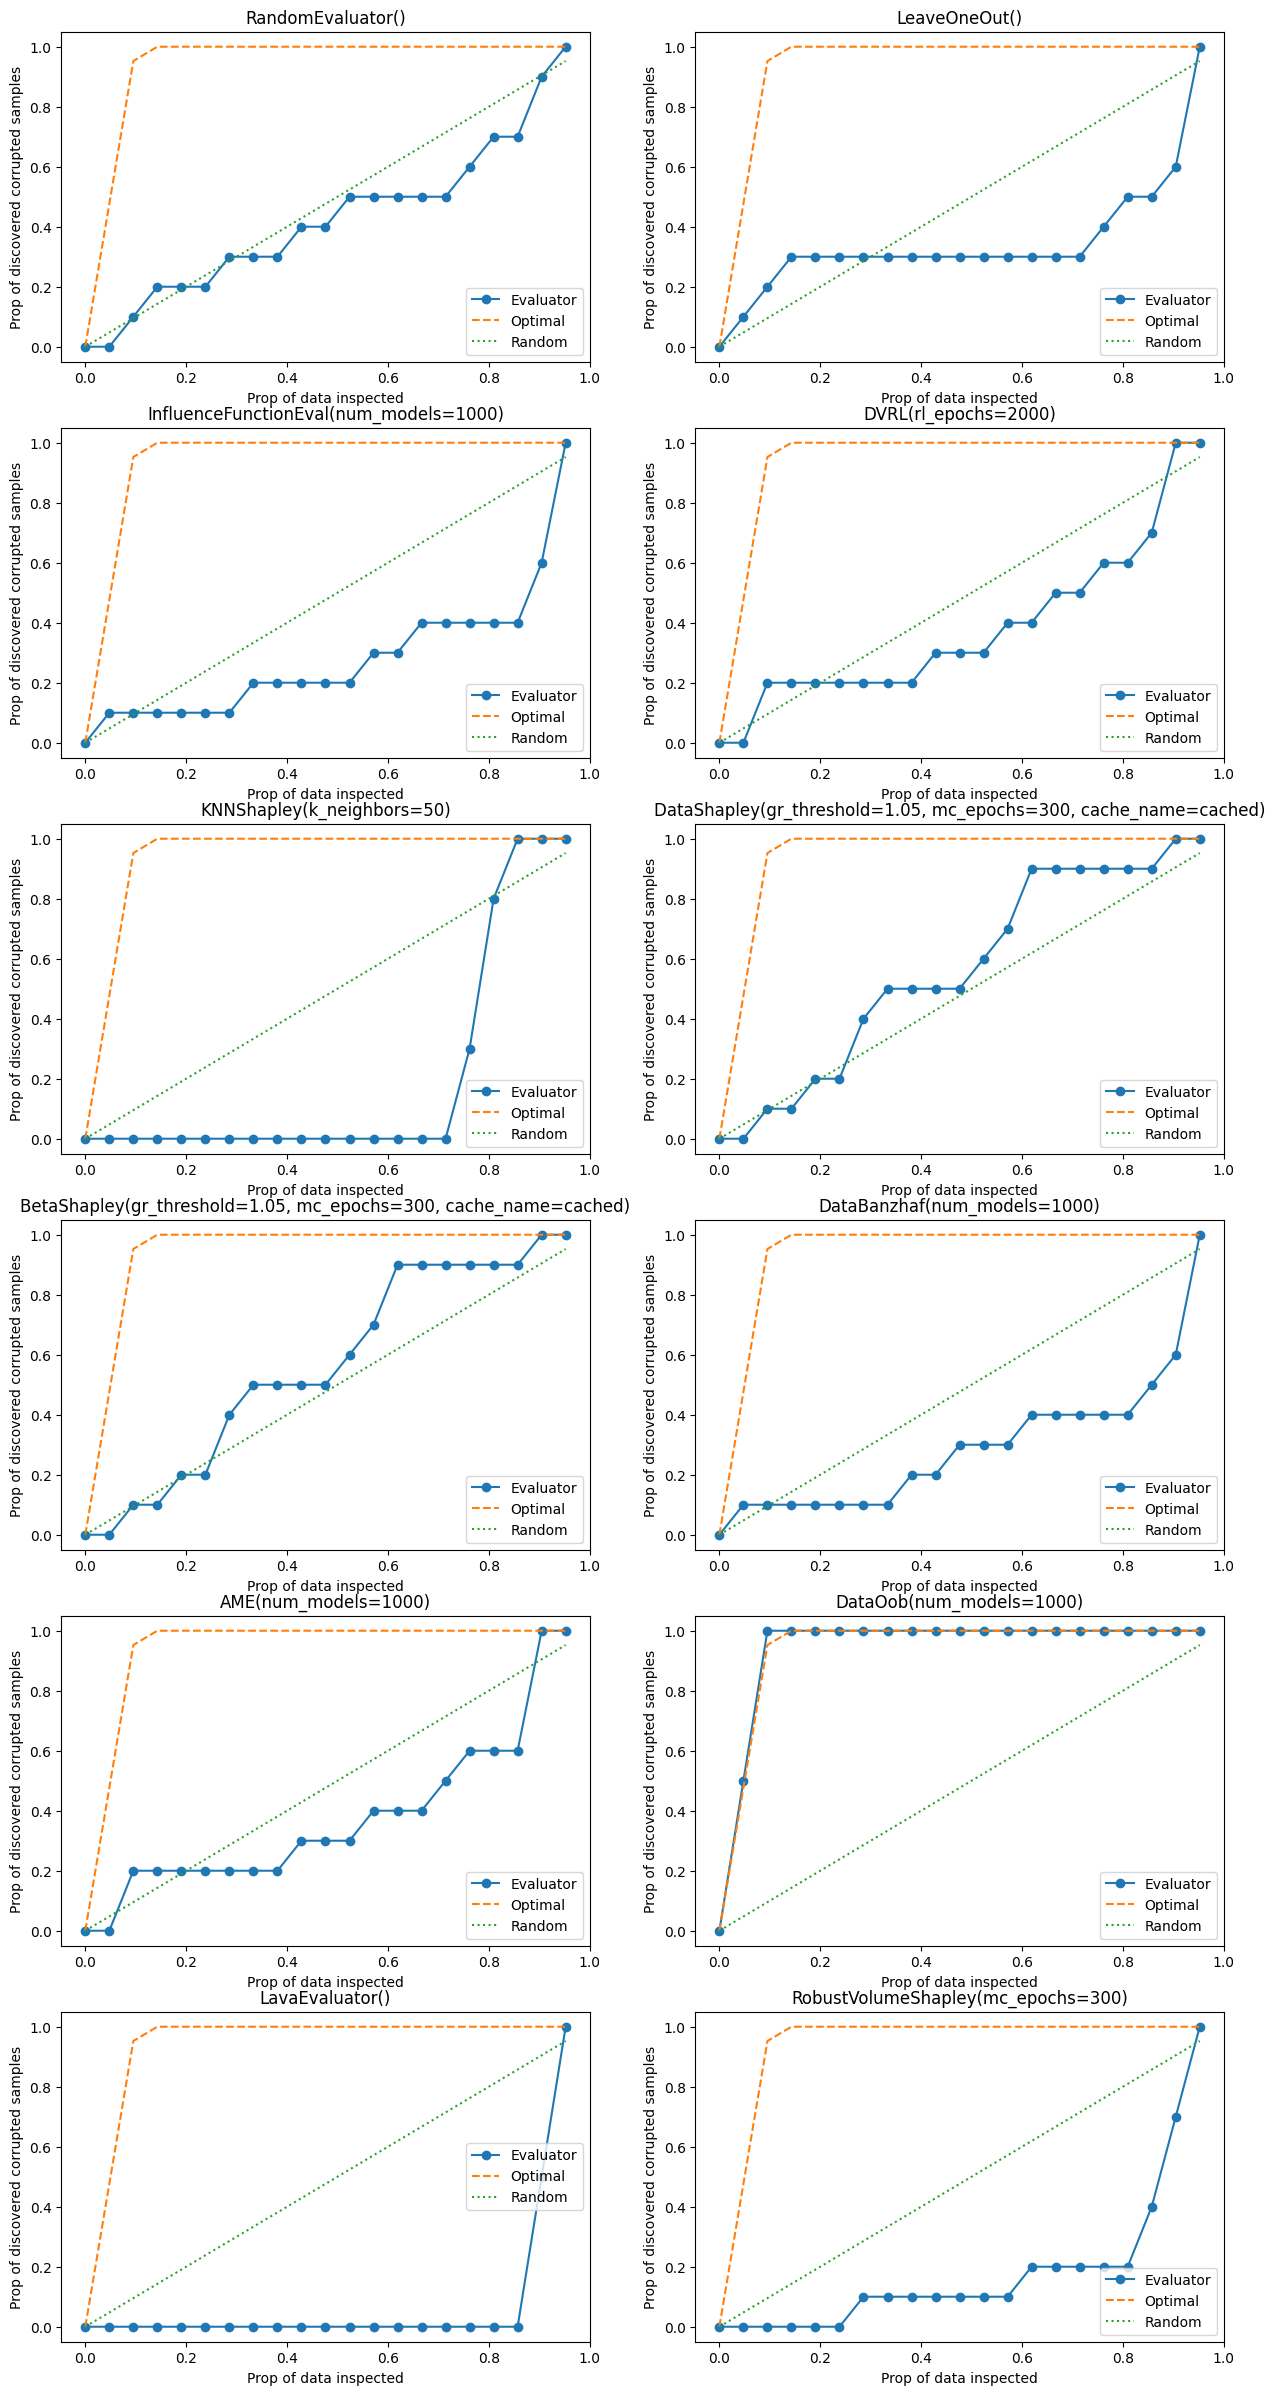

In [7]:
fig = plt.figure(figsize=(15, 30))
_, fig = exper_med.plot(discover_corrupted_sample, fig, col=2, save_output=True)

### Point removal experiment
- `remove_high_low` performs the point removal experiment. Each data valution algorithm, it provides two curves: one is removing data in a descending order (orange), the other is in an ascending order (blue). As for the orange (resp. blue) curve, the lower (resp. upper), the better. 

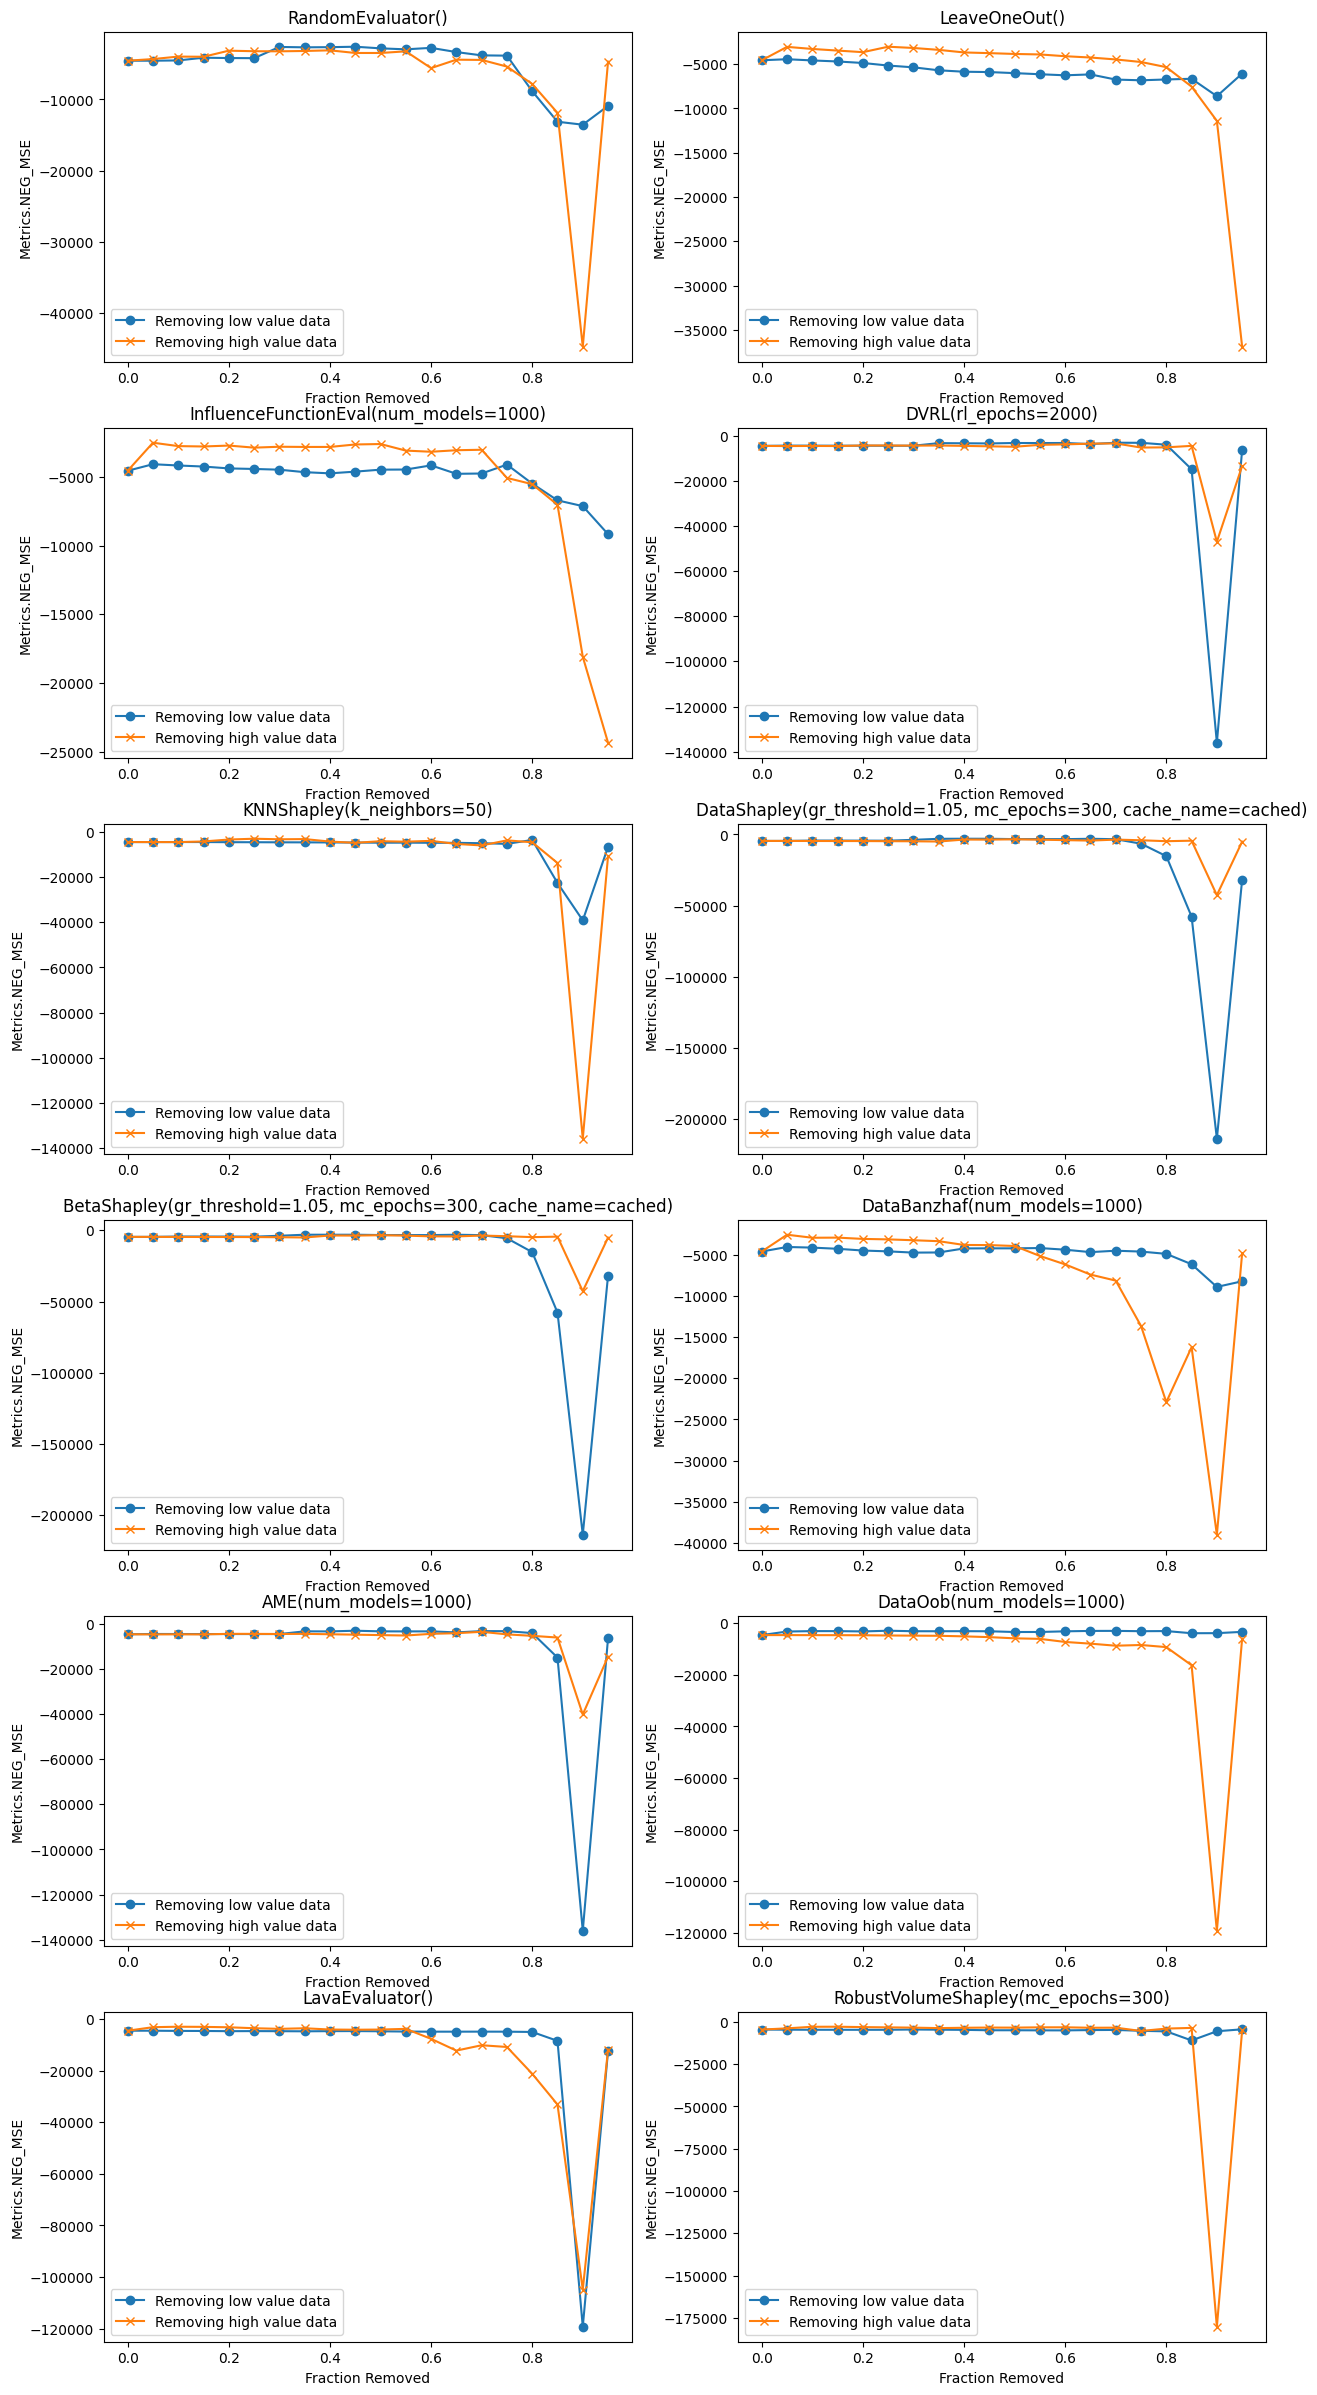

In [8]:
fig = plt.figure(figsize=(15, 30))
df_resp, fig = exper_med.plot(remove_high_low, fig, include_train=True, col=2, save_output=True)

In [9]:
df_resp # it provides complete information for generating point-removal experiment figures.

,remove_least_influential_first_Metrics.NEG_MSE,remove_most_influential_first_Metrics.NEG_MSE,axis
RandomEvaluator(),-4565.477051,-4565.477051,0.0
RandomEvaluator(),-4565.896484,-4334.609375,0.05
RandomEvaluator(),-4525.375,-3987.274902,0.1
RandomEvaluator(),-4144.461914,-4010.947754,0.15
RandomEvaluator(),-4191.483398,-3156.663086,0.2
...,...,...,...
RobustVolumeShapley(mc_epochs=300),-5306.671387,-5396.63623,0.75
RobustVolumeShapley(mc_epochs=300),-5631.331055,-3981.972168,0.8
RobustVolumeShapley(mc_epochs=300),-10994.772461,-3580.094727,0.85
RobustVolumeShapley(mc_epochs=300),-5557.047363,-180278.5625,0.9


### Save data values
- `save_dataval` stores computed data values at `{output_dir}/save_dataval.csv`.

In [10]:
exper_med.evaluate(save_dataval, save_output=True)

,indices,data_values
RandomEvaluator(),414,0.740917
RandomEvaluator(),175,0.701318
RandomEvaluator(),62,0.702994
RandomEvaluator(),169,0.860976
RandomEvaluator(),205,0.120545
...,...,...
RobustVolumeShapley(mc_epochs=300),422,0.0
RobustVolumeShapley(mc_epochs=300),67,0.0
RobustVolumeShapley(mc_epochs=300),346,0.0
RobustVolumeShapley(mc_epochs=300),343,0.0
